In [1]:
from math import e, factorial,log, gamma, sqrt, floor
from matplotlib import pyplot as pt
from numpy.random import geometric,exponential,poisson
from scipy.stats import ks_2samp
from scipy.stats import norm
from numpy import linspace
from IPython.display import Markdown
from analysis import *

# Load data

This is a comment


In [2]:
f1 = open("r1-d0-result.txt")
raw1 = f1.read()
f1.close()

f2 = open("r1-d1-result.txt")
raw2 = f2.read()
f2.close()

f3 = open("r3-d0-result.txt")
raw3 = f3.read()
f3.close()

f4 = open("r3-d1-result.txt")
raw4 = f4.read()
f4.close()

f5 = open("r5-d0-result.txt")
raw5 = f5.read()
f5.close()

f6 = open("r5-d1-result.txt")
raw6 = f6.read()
f6.close()

f7 = open("r7-d0-result.txt")
raw7 = f7.read()
f7.close()

f8 = open("r7-d1-result.txt")
raw8 = f8.read()
f8.close()

f9 = open("r9-d0-result.txt")
raw9 = f9.read()
f9.close()

f10 = open("r9-d1-result.txt")
raw10 = f10.read()
f10.close()



In [3]:
Ttx = 22
Trx = 60
Tn = 100
    
def compute_histogram(r1,r2):

    Eb1,Es1,En1 = computeEvents(r1,Ttx,Trx,Tn)
    Eb2,Es2,En2 = computeEvents(r2,Ttx,Trx,Tn)
    display(Markdown('<span style="color: #af0000">'+"P(S) = %.6f"%(Trx*Es1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #00af00">'+"P(N) = %.6f"%(Tn*En1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #0000af">'+"P(B) = %.6f"%(Ttx*Eb1/len(r1))+'</span>'))

    Pb2 = Eb2*Ttx/(Eb2*Ttx+En2*Tn+Es2*Trx)
    rt1 = Pb2/(Ttx/1000)
    
    print("r(B)(Events/s) = %.6f"%(rt1))
    
    hist1 = genWindowHistogram(r1,r2,1000,Eb2)
    Esuc = checkSuccess(r2,r1)
    Ps=Esuc/Eb2
    rs2 = Esuc*1000/len(r1)
    print("r(Suuccess)(Events/s) = %.6f"%rs2)
    Pscan = Trx*Es1/len(r1)
    r_scan = 1000*Pscan/Trx
    print("r(S)(Events/s) = %.6f"%r_scan)
    Ns = Ps*1000/Ttx
    Nb = rt1*1000
    print("Success probability evts: %.6f"%(Ps))
    return hist1,Eb1,Es1,En1,Ps

In [4]:
hist1,Eb1,Es1,En1,Ps1 = compute_histogram(raw1,raw2)
print(1-hist1[0])
print('---------------------')
hist2,Eb2,Es2,En2,Ps2 = compute_histogram(raw3,raw4)
print(1-hist2[0])
print('---------------------')
hist3,Eb3,Es3,En3,Ps3 = compute_histogram(raw5,raw6)
print(1-hist3[0])
print('---------------------')
hist4,Eb4,Es4,En4,Ps4 = compute_histogram(raw7,raw8)
print(1-hist4[0])
print('---------------------')
hist5,Eb5,Es5,En5,Ps5 = compute_histogram(raw9,raw10)
print(1-hist4[0])
print('---------------------')

<span style="color: #af0000">P(S) = 0.099557</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.861293</span>

r(B)(Events/s) = 40.726467
1.0000000000000002
r(Suuccess)(Events/s) = 3.891903
r(S)(Events/s) = 1.659289
Success probability evts: 0.099428
0.8299332775612642
---------------------


<span style="color: #af0000">P(S) = 0.299967</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.669597</span>

r(B)(Events/s) = 31.377619
0.9999999999999999
r(Suuccess)(Events/s) = 9.127099
r(S)(Events/s) = 4.999454
Success probability evts: 0.299938
0.9959249048553873
---------------------


<span style="color: #af0000">P(S) = 0.500220</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.478051</span>

r(B)(Events/s) = 22.230906
1.0
r(Suuccess)(Events/s) = 10.873767
r(S)(Events/s) = 8.336993
Success probability evts: 0.500185
0.9993505634463433
---------------------


<span style="color: #af0000">P(S) = 0.699757</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.287189</span>

r(B)(Events/s) = 13.214650
0.9999999999999998
r(Suuccess)(Events/s) = 9.122777
r(S)(Events/s) = 11.662619
Success probability evts: 0.699271
0.9996984571883357
---------------------


<span style="color: #af0000">P(S) = 0.900172</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.095487</span>

r(B)(Events/s) = 4.367868
1.0
r(Suuccess)(Events/s) = 3.913489
r(S)(Events/s) = 15.002875
Success probability evts: 0.900131
0.9996984571883357
---------------------


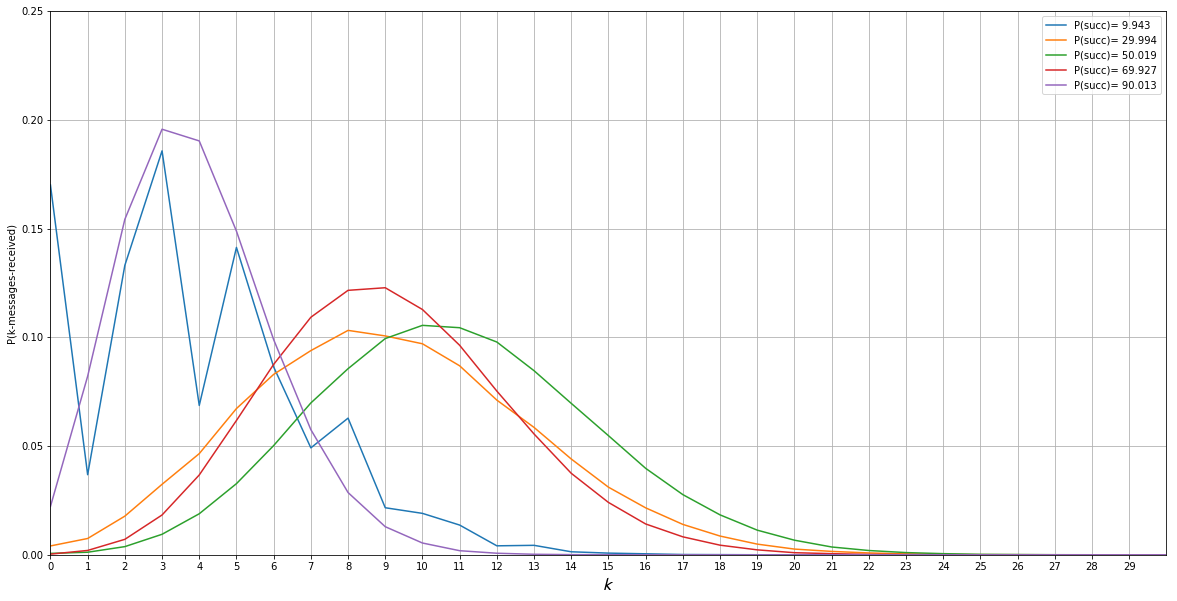

In [5]:
pt.rcParams["figure.figsize"] = (20,10)
pt.plot(range(len(hist1)),hist1,label="P(succ)= %.3f"%(100*Ps1))
pt.plot(range(len(hist2)),hist2,label="P(succ)= %.3f"%(100*Ps2))
pt.plot(range(len(hist3)),hist3,label="P(succ)= %.3f"%(100*Ps3))
pt.plot(range(len(hist4)),hist4,label="P(succ)= %.3f"%(100*Ps4))
pt.plot(range(len(hist5)),hist5,label="P(succ)= %.3f"%(100*Ps5))


pt.legend()
pt.axis([0,30,0,0.25])
pt.xticks(range(30), [str(n) for n in range(30)])
pt.xlabel(r'$\mathcal{k}$', fontsize = 18)
pt.ylabel(r'P(k-messages-received)')
pt.savefig('test.svg',format='svg',dpi=300, bbox_inches='tight')
pt.grid(True)
pt.show()